# Model Building

We want to predict the minute by minute crypto currency prices based on the prices on the past time stamps. This problem is sequential prediction. It is one of the hardest problems in data science industry. Often **Long Short Term Memory**, a variant of recurrent neural network, is used to solve sequential prediction. https://en.wikipedia.org/wiki/Long_short-term_memory

**Because of the nature of Long Short Term Memory, k-cross validation is inappropriate in this case** if you do k-cross validation on this problem, you would be **predicting past stock prices based on future stock prices** For example, LSTM will predict the stock price on Friday based on Mon-Thursday's prices, therefore Friday is appropriate validation set in this case. However if you do k-cross validation, they will make Monday's stock price as one of validation sets, you will predict it based on Tuesday-Friday stock prices. LSTM does not work like that and I do not think predicting past stock prices will bring much business values. For the same reason, shuffling the data set is also inappropriate to this problem

A validation set for LSTM must be continuation from the training set, therefore I will use a single validation=test set

In [0]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
import matplotlib.pyplot as plt

In [0]:
dataset = pd.read_csv('bitmex_prices .csv')


## Feature Selection
Because we are now using LSTM, the custom features I created do not have much use. It is because, LSTM model stores the past stock prices in itself and optimize it as its weights. Instead of using feature such as "difference from average price of last 60 mins", I will just make the model predict stock price based on past 60 minutes prices

In [0]:
prices = dataset['xbtusd'].to_numpy()
prices

array([ 5053.25,  5053.25,  5053.25, ..., 12535.25, 12536.75, 12536.75])

In [0]:
scaler = MinMaxScaler(feature_range=(0,1))
prices_scaled = scaler.fit_transform(prices.reshape(-1, 1))
prices_scaled.shape[0]*0.8

**The data is now scaled to the range 0-1**

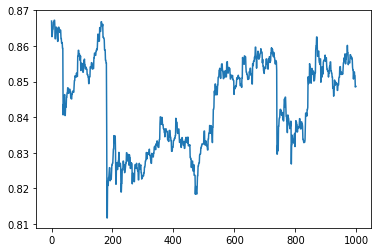

In [0]:
plt.plot(prices_scaled[-1000:])

Using last 60 minutes time steps to predict next price <br>
for example, a sample x contains the price at 1st minute to 60th minute stamp, then the corresponding y will be the price at 61st minute

In [0]:
x, y = [], []
for i in range(60,len(prices_scaled)):
    x.append(prices_scaled[i-60:i])
    y.append(prices_scaled[i])
x, y = np.array(x), np.array(y)


In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, shuffle=False)
y_train.shape

(91396, 1)

In [0]:
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

In [0]:
X_train.shape

(91396, 60, 1)

**Long Shot Term Memory Model**

In [0]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()
model.fit(X_train, y_train, epochs=1, batch_size=1, verbose=1)

W0719 14:27:19.716487 140375785535360 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0719 14:27:19.765002 140375785535360 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0719 14:27:19.777117 140375785535360 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0719 14:27:20.242657 140375785535360 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 60, 50)            10400     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


W0719 14:27:20.544457 140375785535360 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0719 14:27:21.760176 140375785535360 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0719 14:27:21.881016 140375785535360 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Epoch 1/1
91396/91396 [==============================] - 5605s 61ms/step - loss: 2.0106e-05


In [0]:
from keras.models import load_model

model.save('lstm_model.h5')

In [0]:
predictions = model.predict(X_test, verbose=1)

30466/30466 [==============================] - 14s 457us/step


**Scale back the predictions to actual prices**

In [0]:
predictions = scaler.inverse_transform(predictions)
actual_price = scaler.inverse_transform(y_test)

## Prediction on the whole validation set

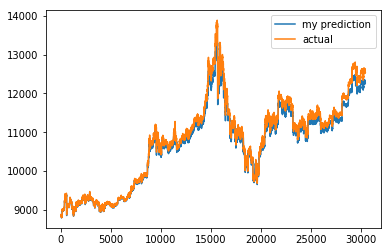

In [0]:
plt.plot(predictions)
plt.plot(actual_price)
plt.legend(['my prediction', 'actual'], loc='upper right')

## First 5000 next minute predictions

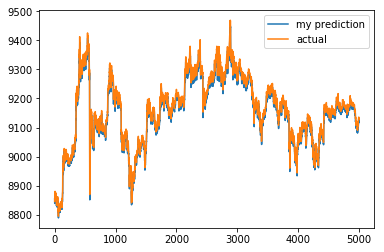

In [0]:
plt.plot(predictions[:5000])
plt.plot(actual_price[:5000])
plt.legend(['my prediction', 'actual'], loc='upper right')

## Last 5000  predictions

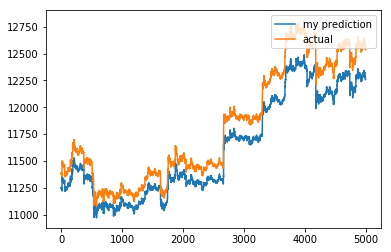

In [0]:
plt.plot(predictions[-5000:])
plt.plot(actual_price[-5000:])
plt.legend(['my prediction', 'actual'], loc='upper right')

**Obsevation :**
The long and short term memory model is doing great job for predicting the price at time stamps which directly after the trainng. However, As I expected, the model is not very good at predicting far future after the last point you trained. Although it follows the same shape, there was some gap between predictions and actual prices in the last 5000 predictions. To solve this problem, we could train model more, if we can train the samples right before the last 5000 timestop, the predictions would be more accurate.